#### includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mlflow
import pytorch_lightning as pl
from pytorch_lightning.utilities.cloud_io import load as pl_load
import torch
import sys



In [3]:
import sources
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils.clip_pad import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase
from src.trainer import BinaryClassifierNet
from sources import load_dataset, parse_config, setup_model

## Constantes

In [4]:
EXP = '/home/gaby/mlflow/mlruns/4/5160045012be4d76af5ecae8ec6f919a/artifacts/'
cfg = parse_config(EXP+'cfg_extended.yaml')
#cfg.training['dataset-file'] = '/home/gaby/These/src/Fundus/RotInvariance/3-Git/vessels.h5'
trainD, validD, testD = load_dataset(cfg)
cfg['script-arguments']['gpus']='0'

## Initialisation

In [5]:
model = setup_model(cfg.model, old=True)
net = BinaryClassifierNet(model=model)
state_dict = pl_load(EXP+'best-val-roc.ckpt'.format(25), map_location='cuda:0')['state_dict']
net.load_state_dict(state_dict)
net.eval().cuda()
None

In [6]:
for d in testD['MESSIDOR']:
    break

In [7]:
THETA = 24
x = torch.from_numpy(rotate(d['x'][0].numpy(), THETA)).cuda()

In [8]:
features = {}
def log_f(name):
    def hook(self, inputs, outputs):
        features[name] = outputs.detach().cpu().numpy()
    return hook
net.model.conv1.relu.register_forward_hook(log_f('conv1'))
net.model.conv2.relu.register_forward_hook(log_f('conv2'))
net.model.conv3.relu.register_forward_hook(log_f('conv3'))
net.model.conv4.relu.register_forward_hook(log_f('conv4'))
net.model.conv10.relu.register_forward_hook(log_f('conv10'))

None

In [9]:
yhat = net(x)
yhat = yhat.detach().cpu().numpy()
yhat = unrotate(yhat, THETA)

## Polar Spectral Power Density

/home/gaby/.conda/envs/nnet/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


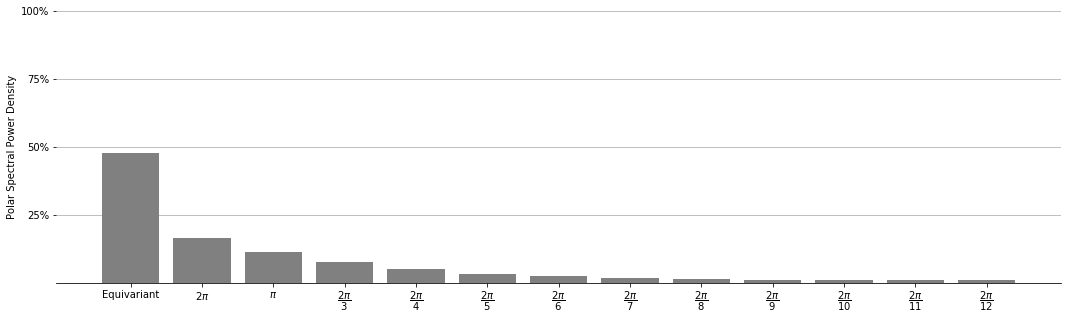

In [10]:
_ = spectral_power(yhat, plot=True)

In [11]:
features = {k: unrotate(v, THETA) for k,v in features.items()}

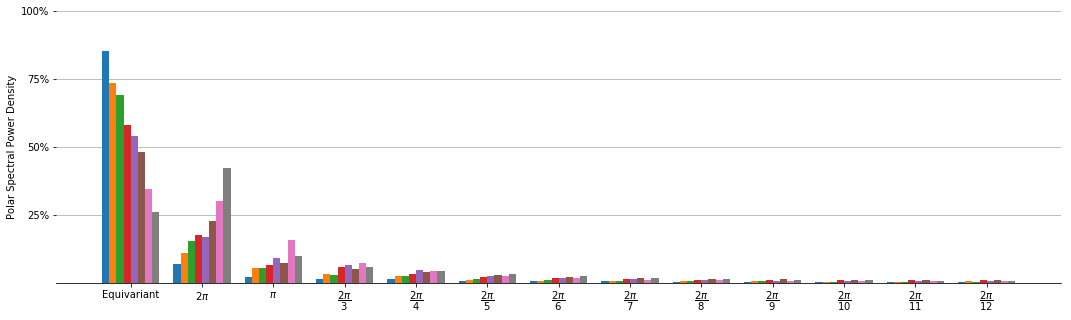

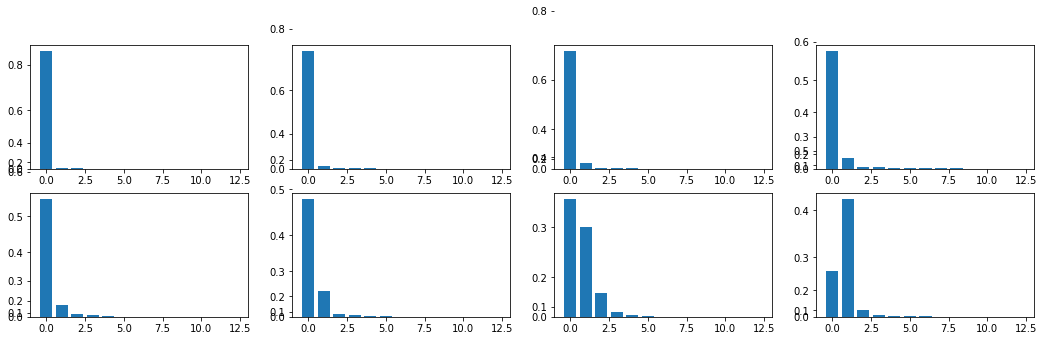

In [12]:
spe = spectral_power(features['conv1'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

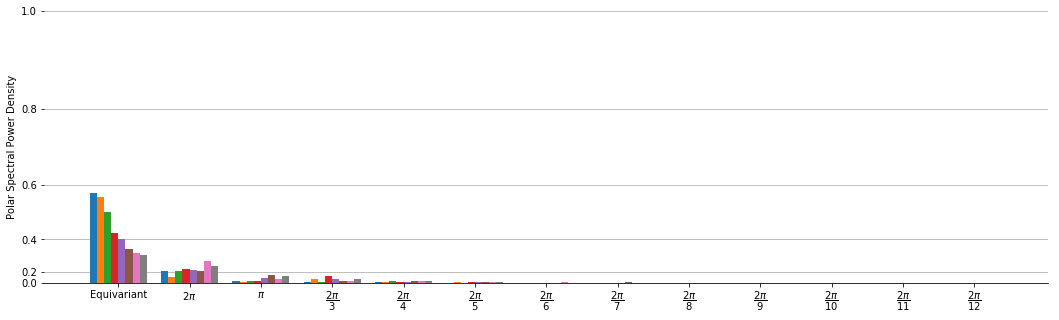

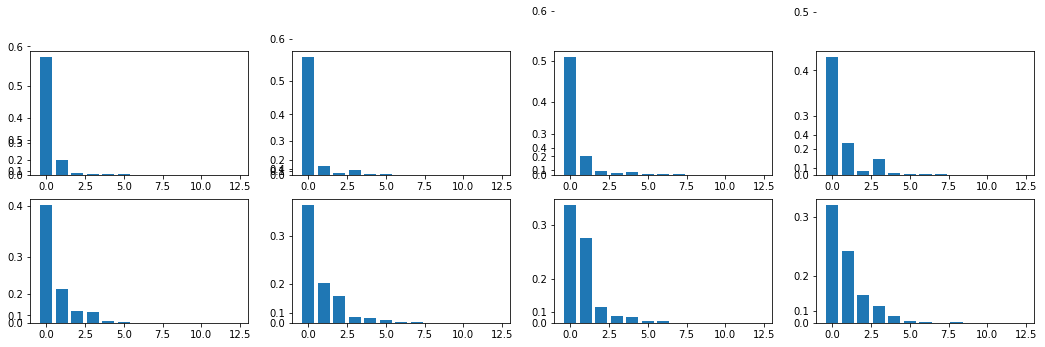

In [13]:
W = net.model.conv1.conv.weight.detach().cpu().numpy()
spe = polar_spectral_power(W, theta=24, plot='sqr', split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

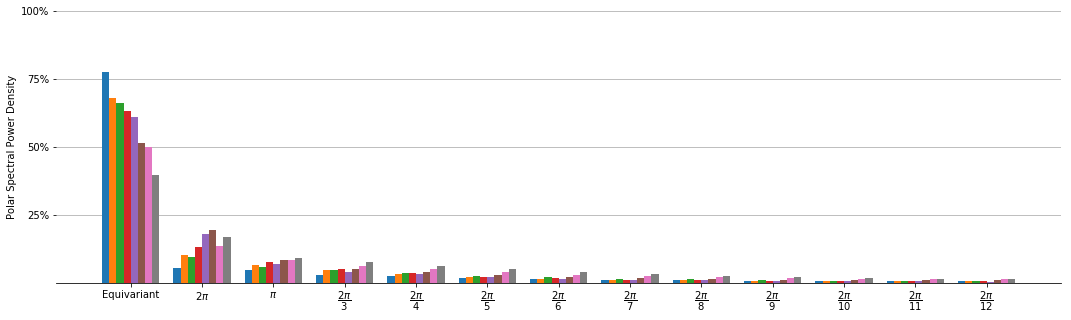

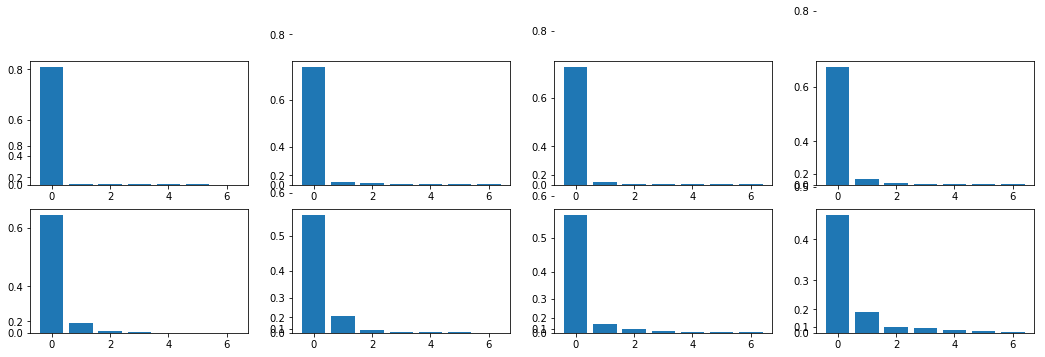

In [14]:
spe = spectral_power(features['conv2'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[0:len(spe)//2+1,i]
    y = y/y.sum()
    x = np.arange(0,len(spe)//2+1)
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

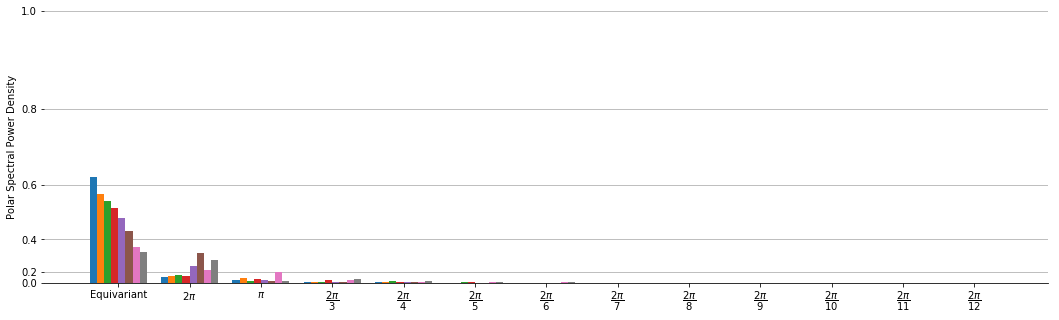

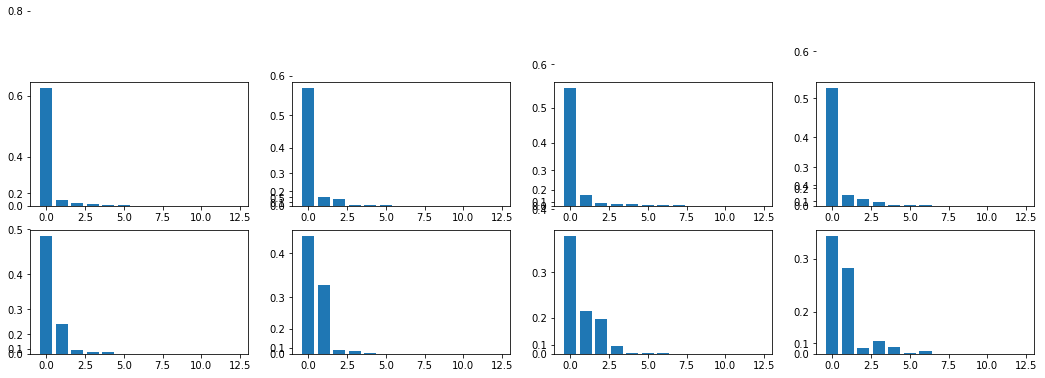

In [15]:
W = net.model.conv2.conv.weight.detach().cpu().numpy()
spe = polar_spectral_power(W, theta=24, plot='sqr', split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

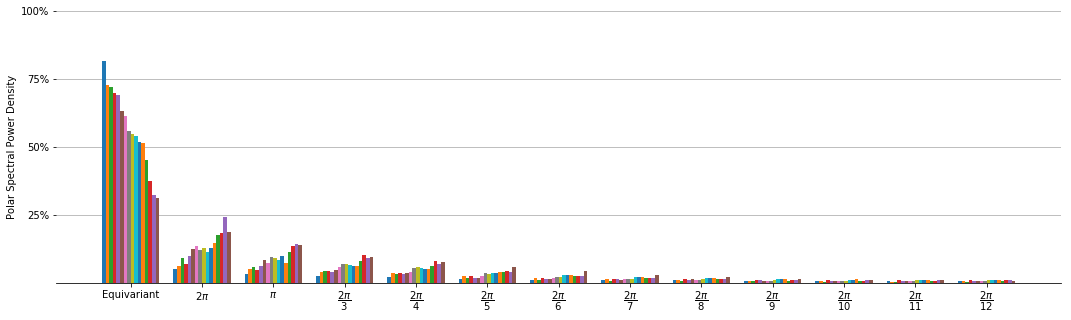

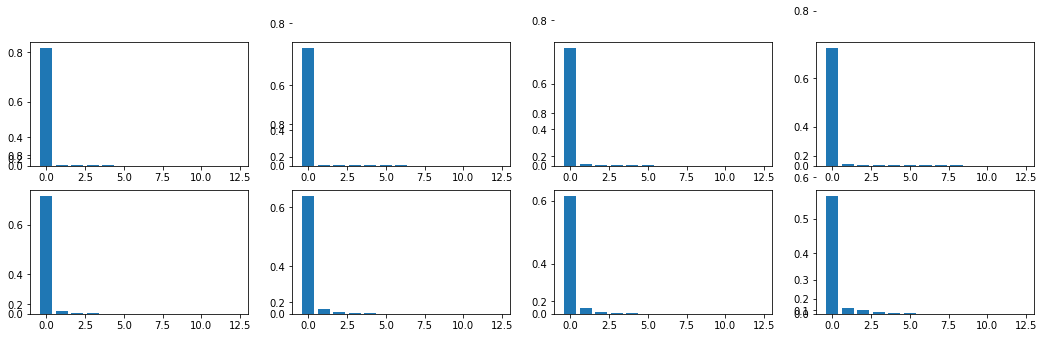

In [16]:
spe = spectral_power(features['conv3'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

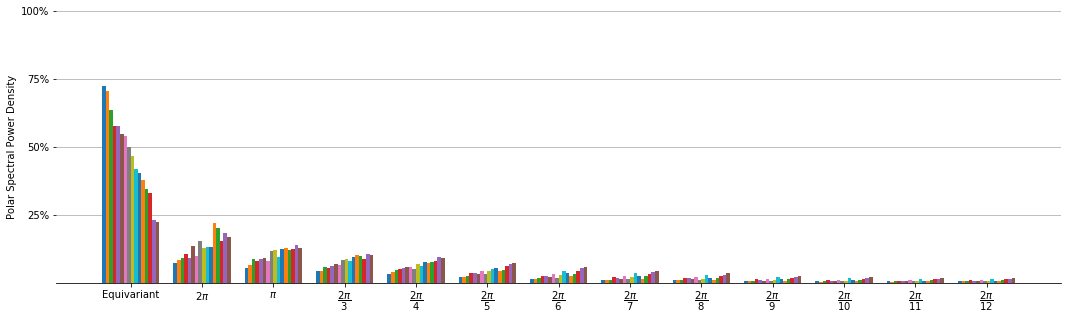

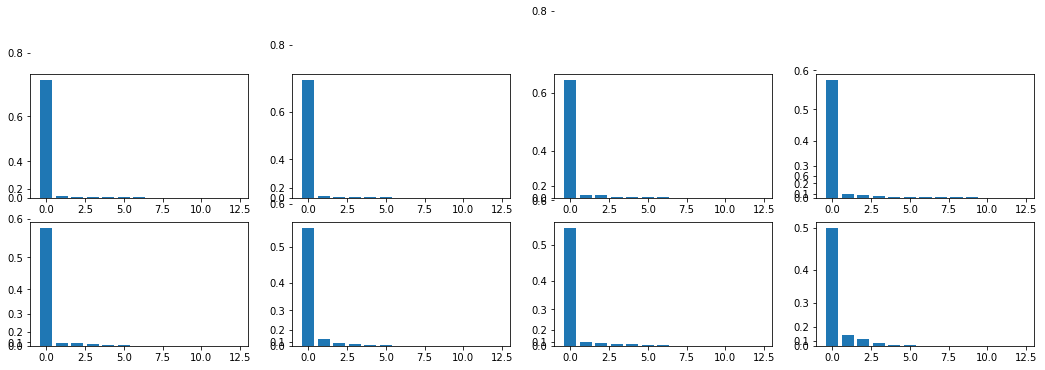

In [17]:
spe = spectral_power(features['conv4'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

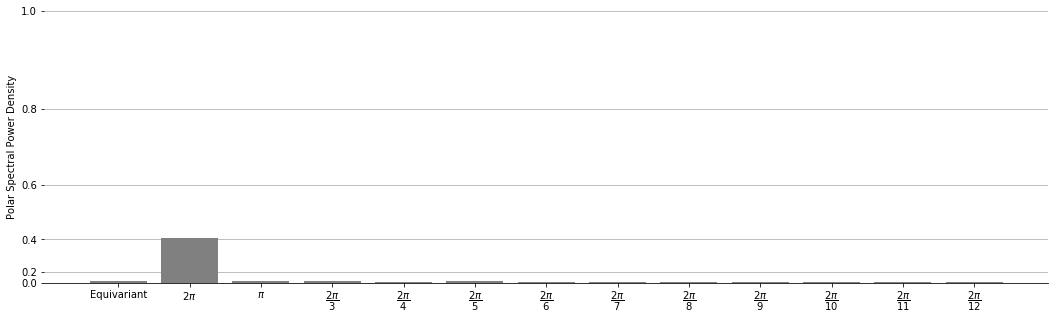

In [18]:
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

grad = np.matmul(np.linspace(-1,1,3)[:,None],np.ones((1,3)))
noise = np.random.uniform(0,1,size=(100,100))
noise = gaussian_filter(noise, 3)
noise = rotate(noise, 24)
r = np.stack([convolve2d(_, grad) for _ in noise])
r = unrotate(r, 24)
spe = spectral_power(r, plot='sqr')

Equivariant features: 107/128


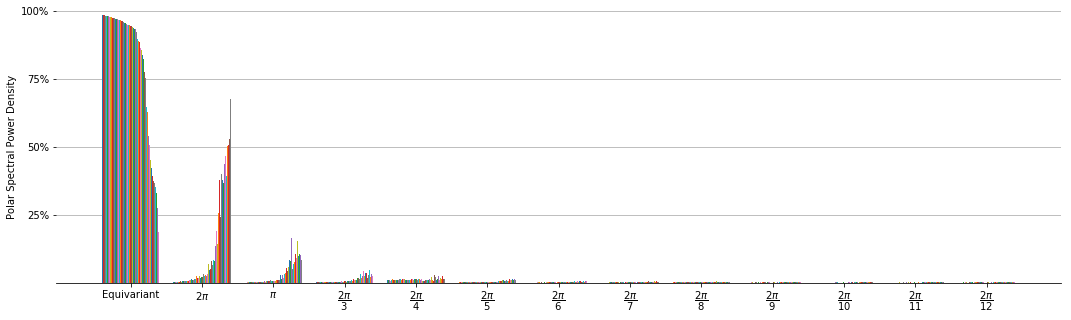

In [19]:
spe = spectral_power(features['conv10'], plot=True, split='normed')
spe = spe / spe.sum(axis=0)
print(f"Equivariant features: {(spe[0]>=.5).sum()}/{spe.shape[1]}")

## Steerable Filters

### Polar Spectral Power Density

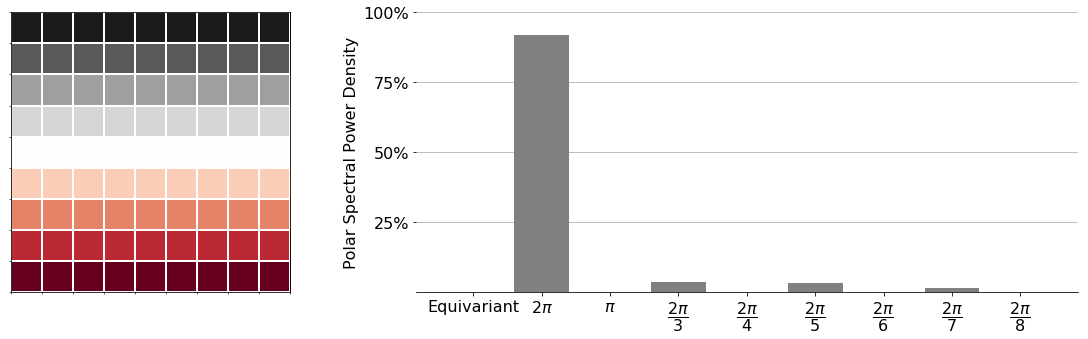

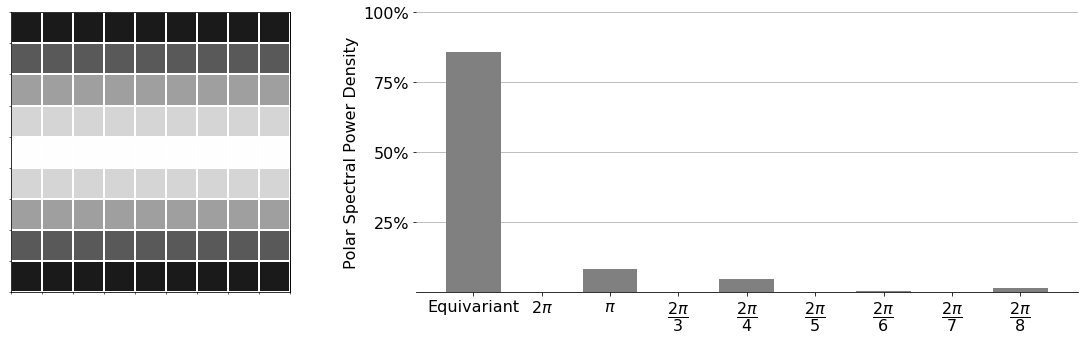

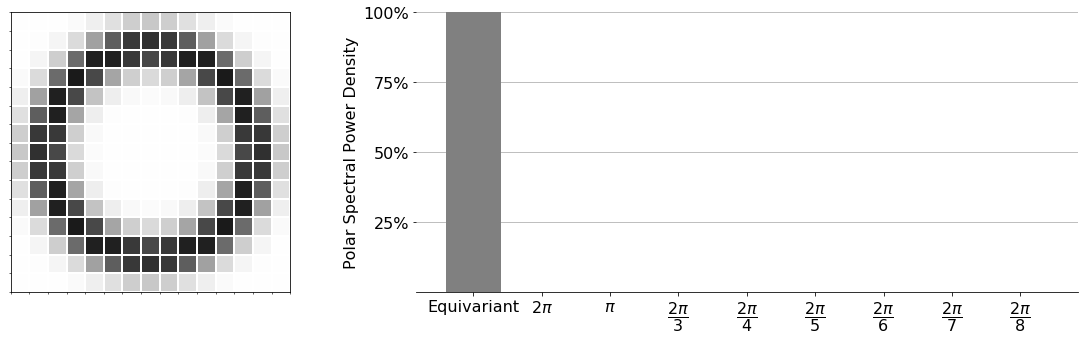

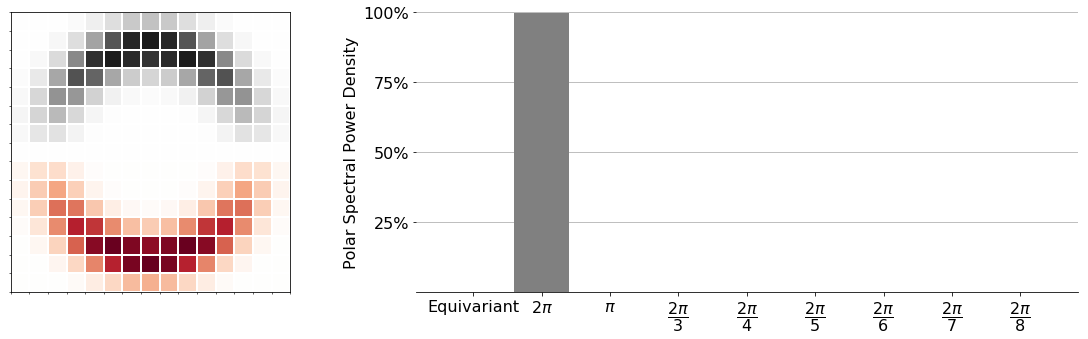

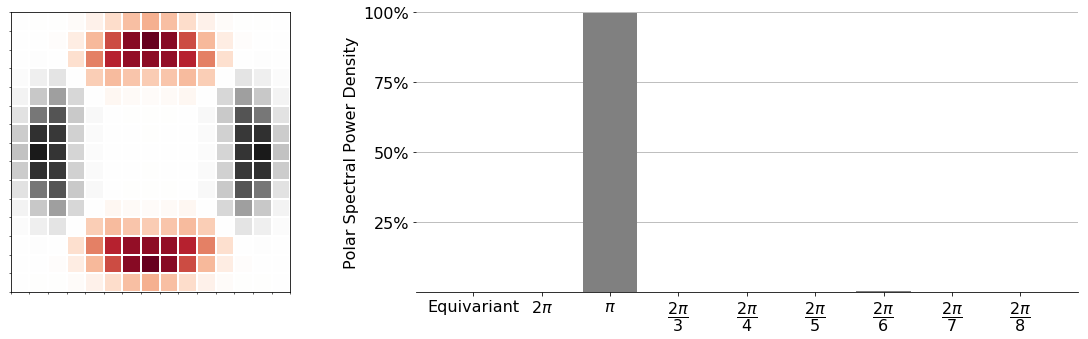

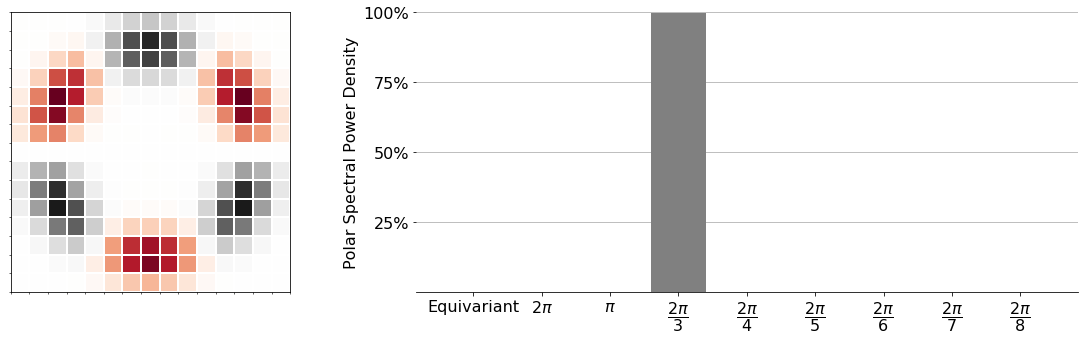

In [20]:
plt.rcParams.update({'font.size': 16})
F0a = np.ones((1,9))*np.arange(-4,5)[:, np.newaxis]
plot_filter(np.real(F0a), axis=False, spd=True)
F0b = np.ones((1,9))*-np.abs(np.arange(-4,5)[:, np.newaxis])
plot_filter(np.real(F0b), axis=False, spd=True)

F0 = radial_steerable_filter(15, k=0,r=6, std=1)
plot_filter(-np.real(F0), axis=False, spd=True)
F1 = radial_steerable_filter(15, k=1,r=6, std=1)
plot_filter(np.real(F1), axis=False, spd=True)
F2 = radial_steerable_filter(15, k=2,r=6, std=1)
plot_filter(np.real(F2), axis=False, spd=True)
F3 = radial_steerable_filter(15, k=3,r=6, std=1)
plot_filter(np.real(F3), axis=False, spd=True)

### Steerable Filters

34


/home/gaby/.conda/envs/nnet/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


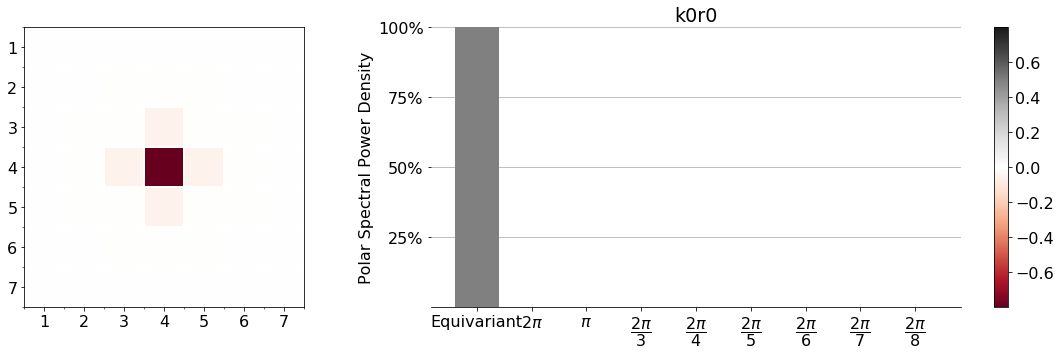

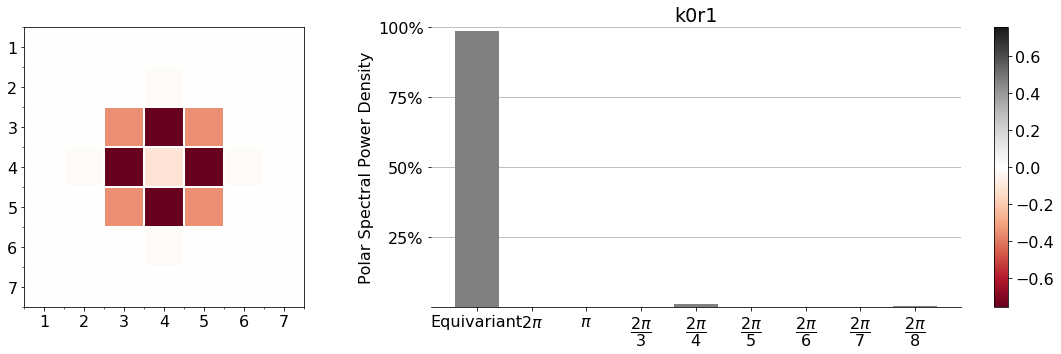

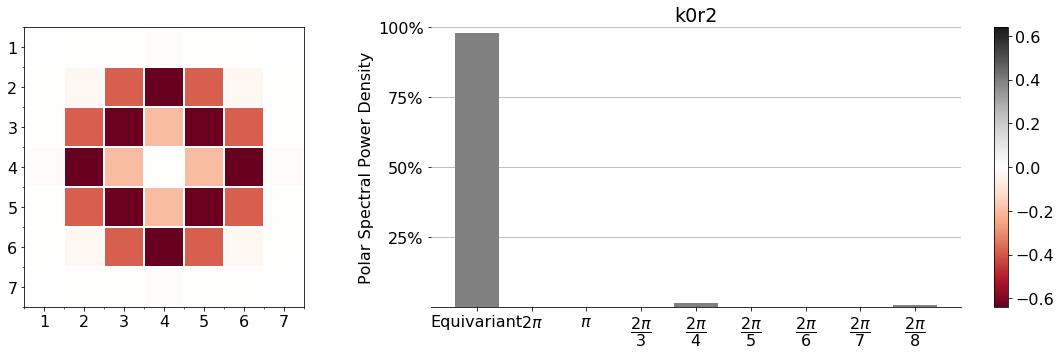

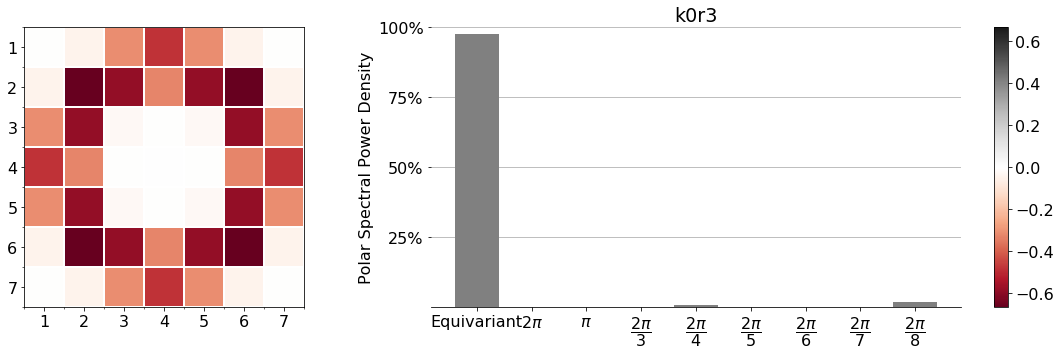

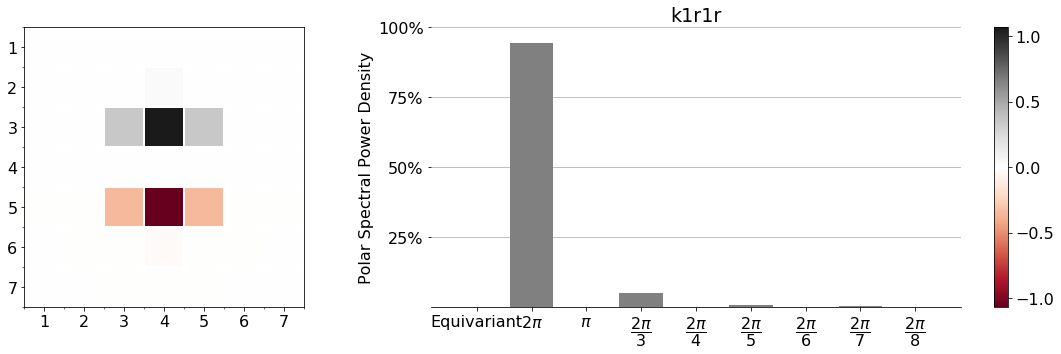

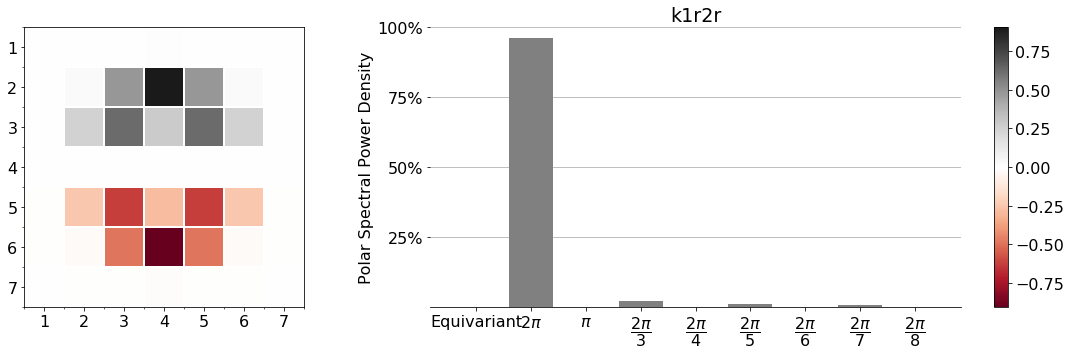

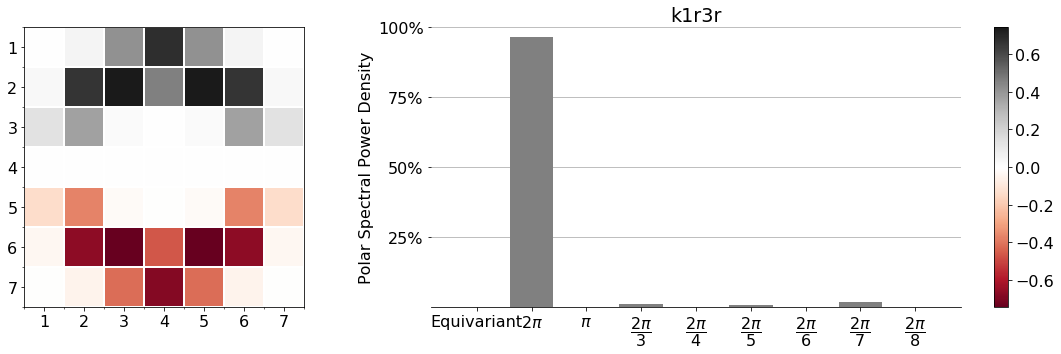

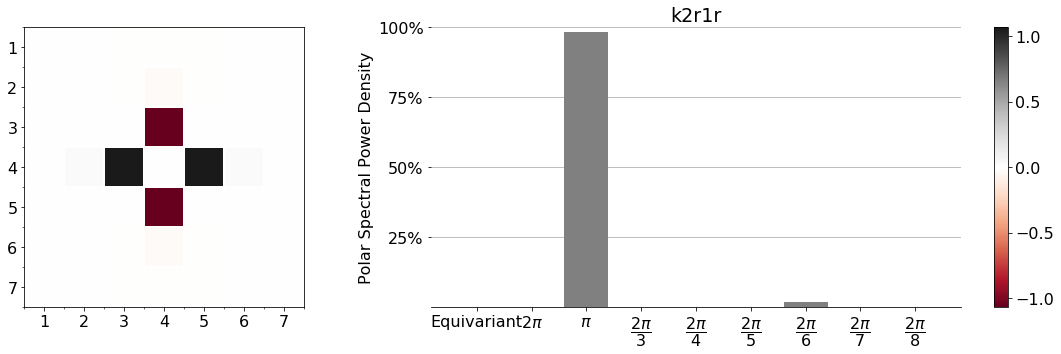

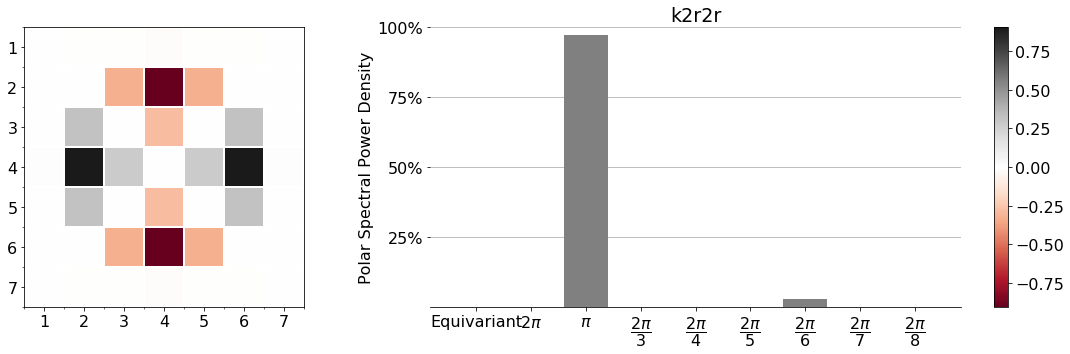

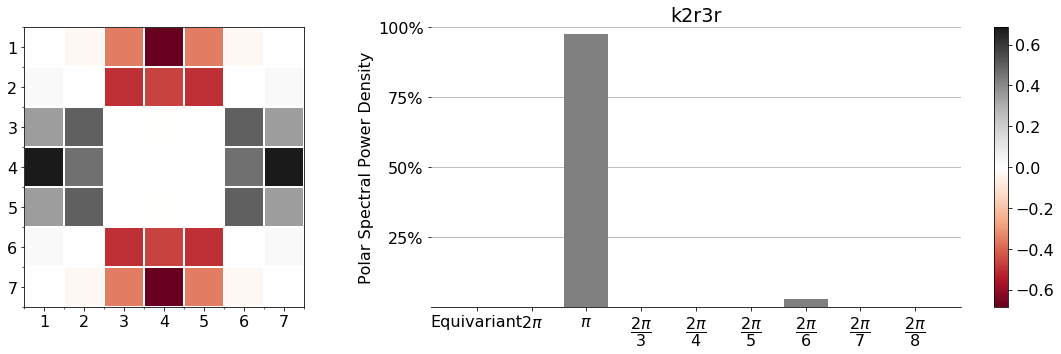

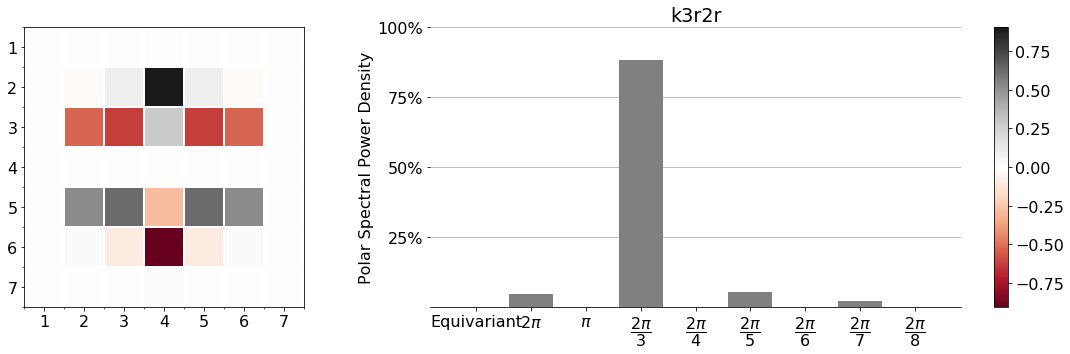

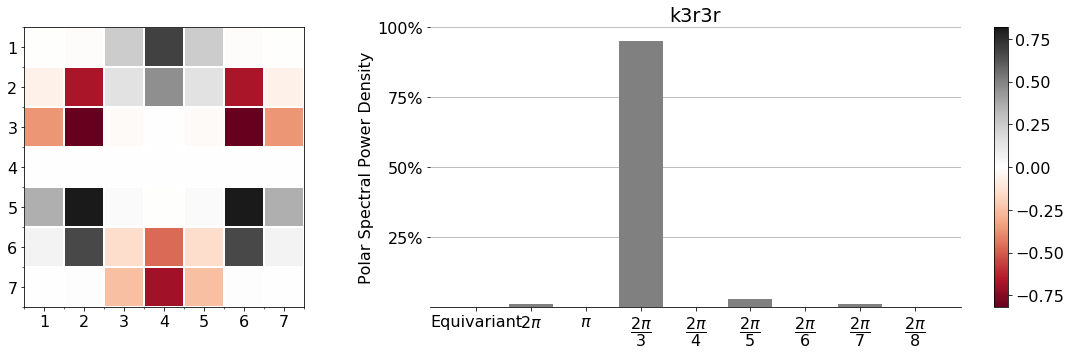

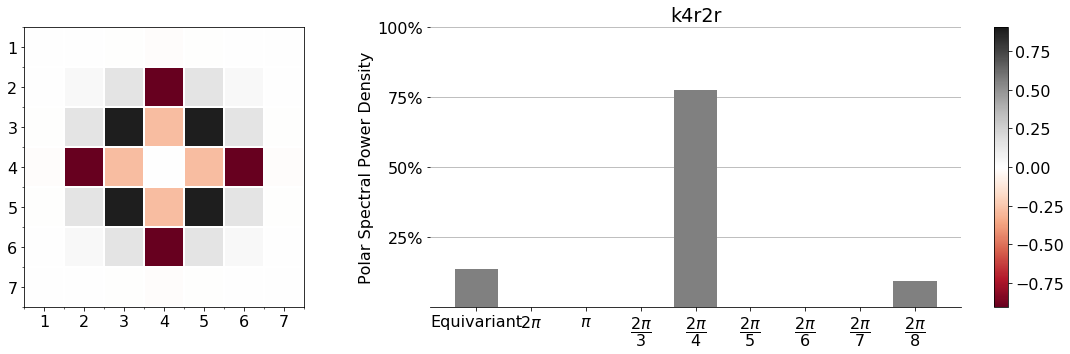

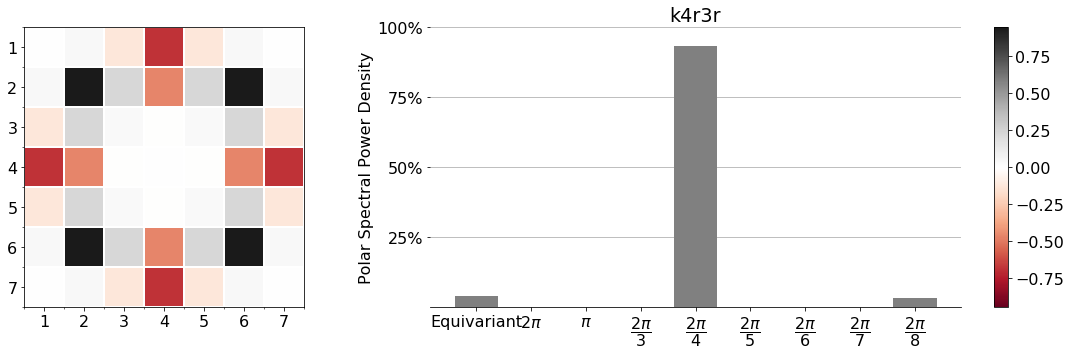

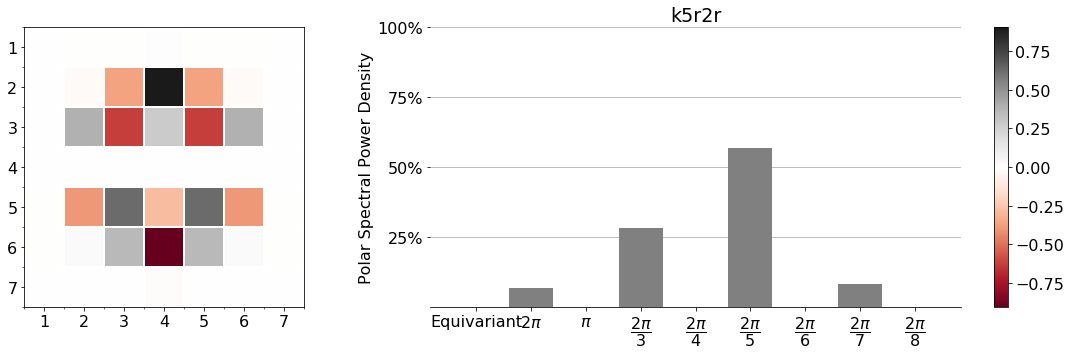

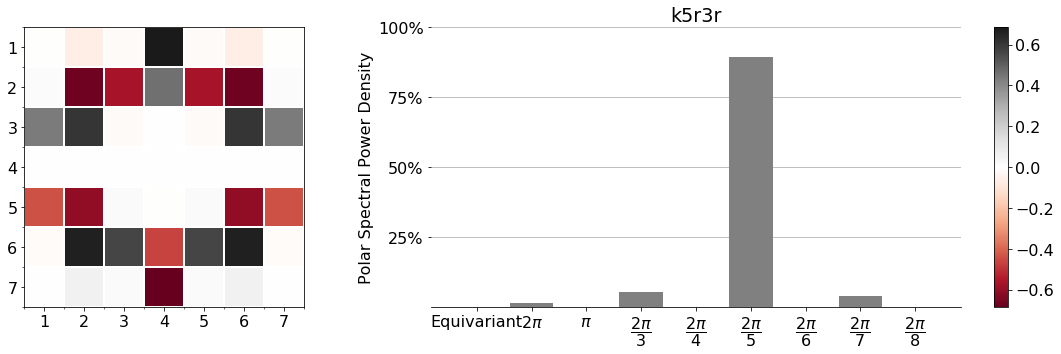

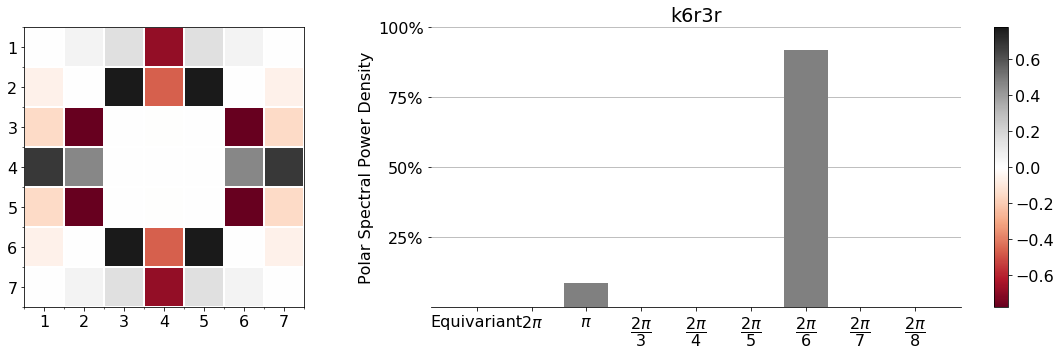

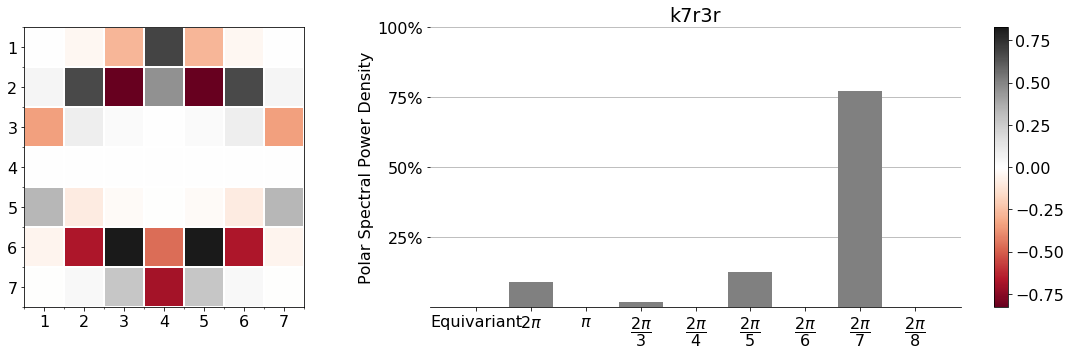

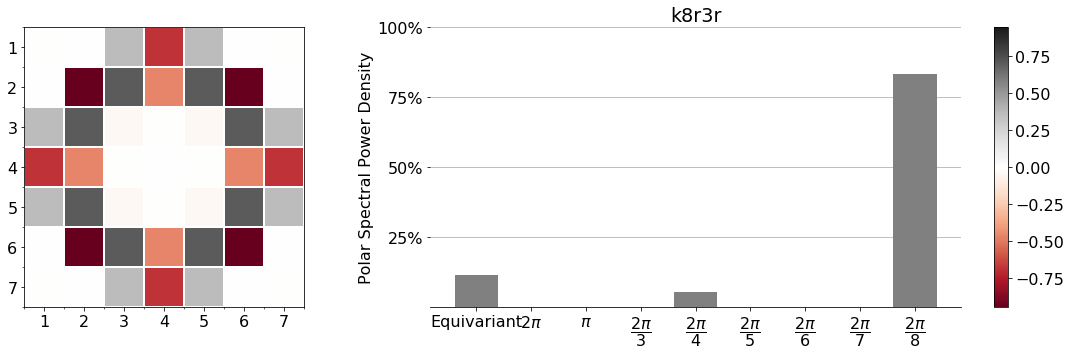

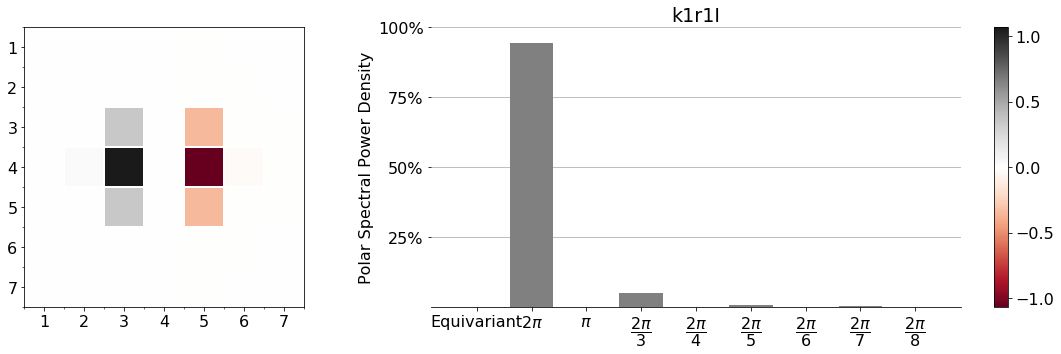

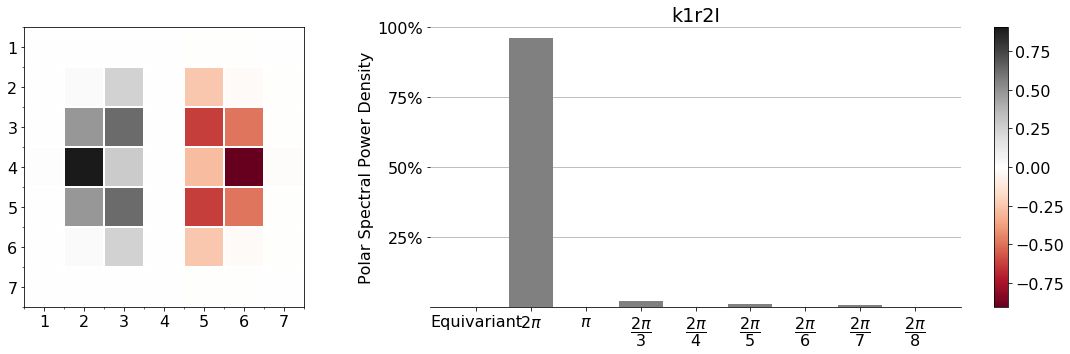

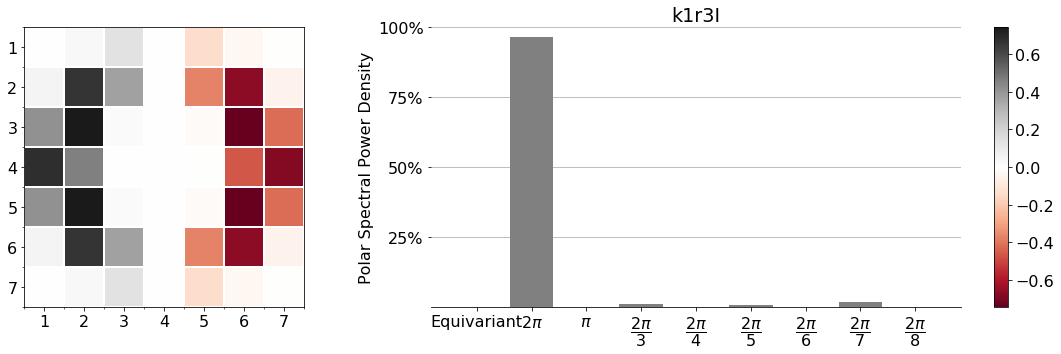

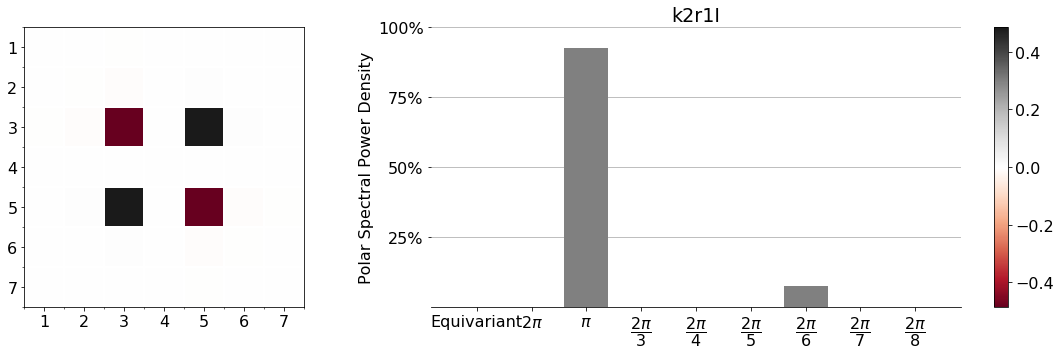

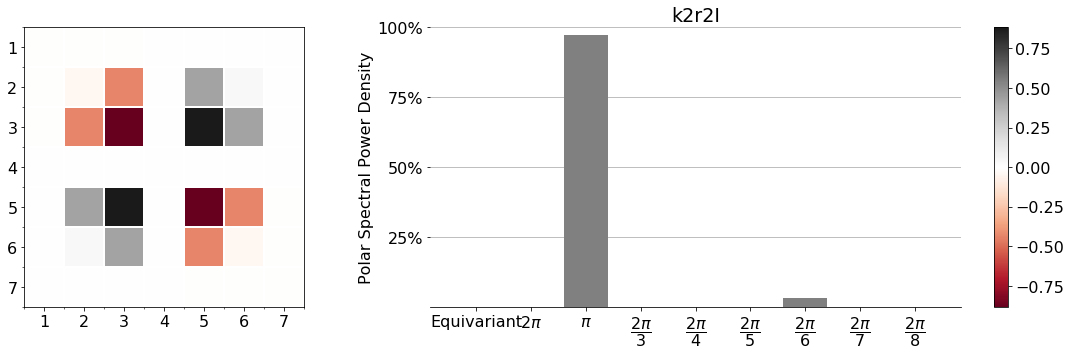

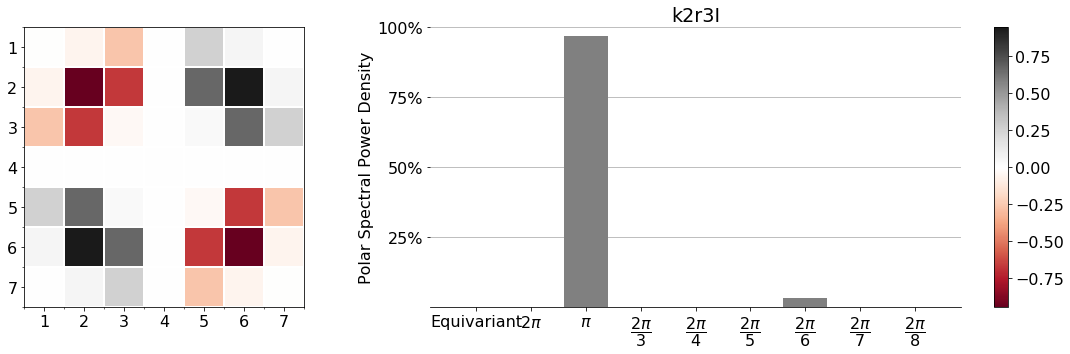

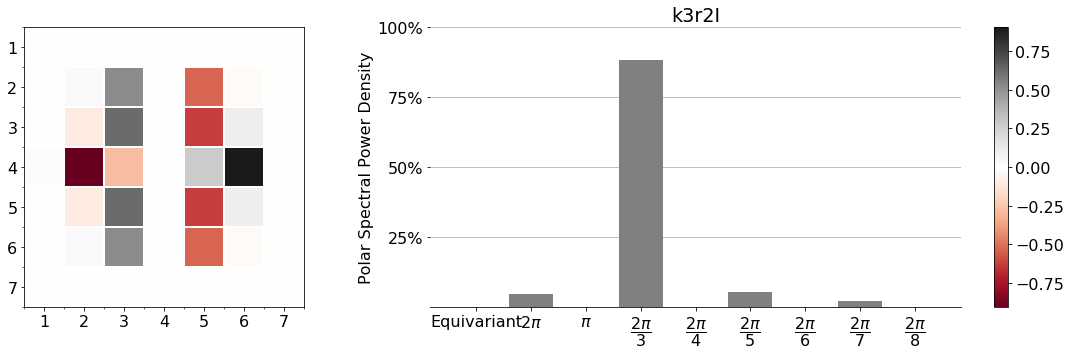

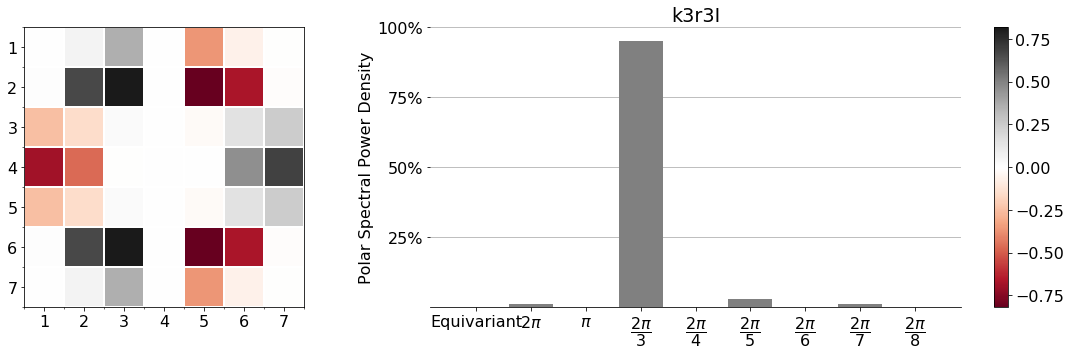

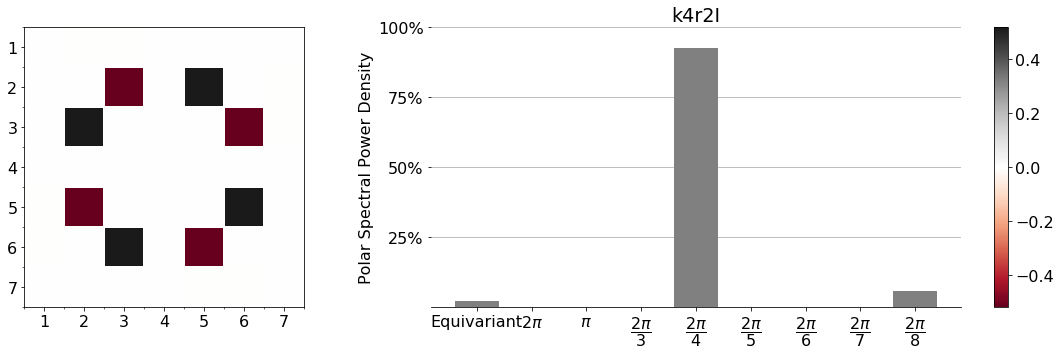

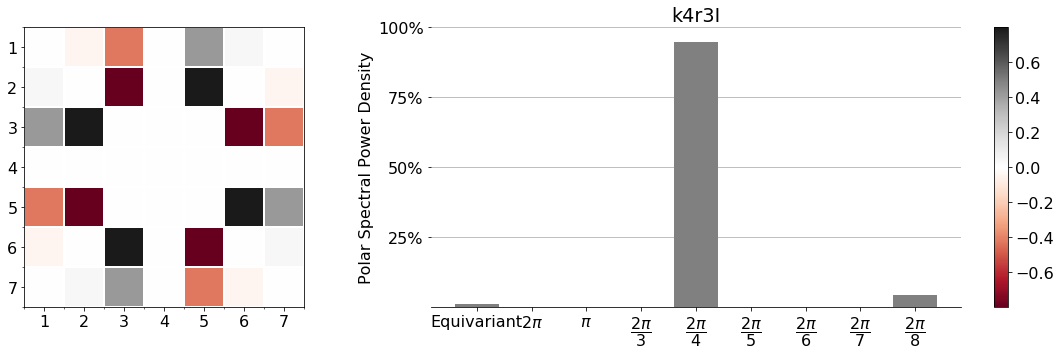

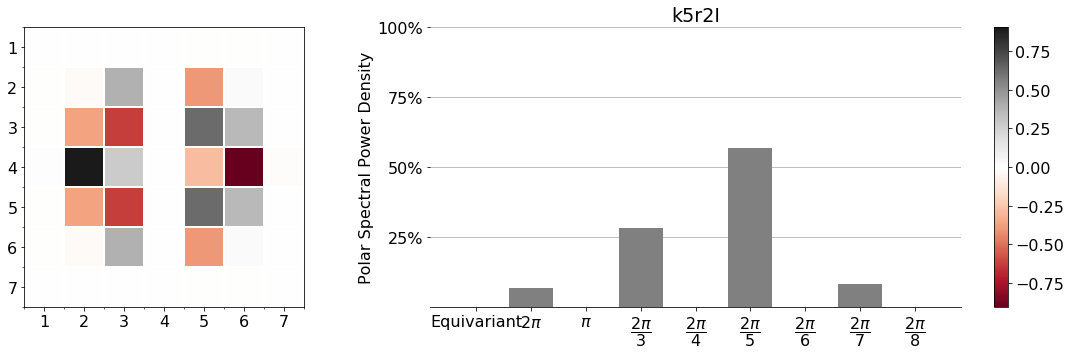

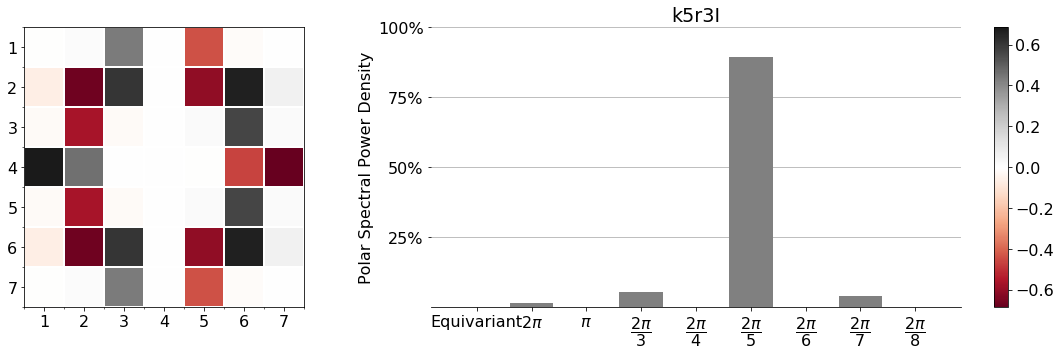

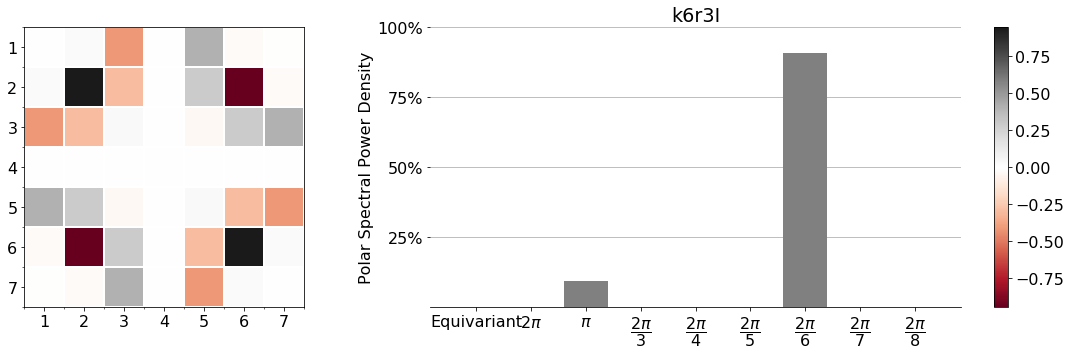

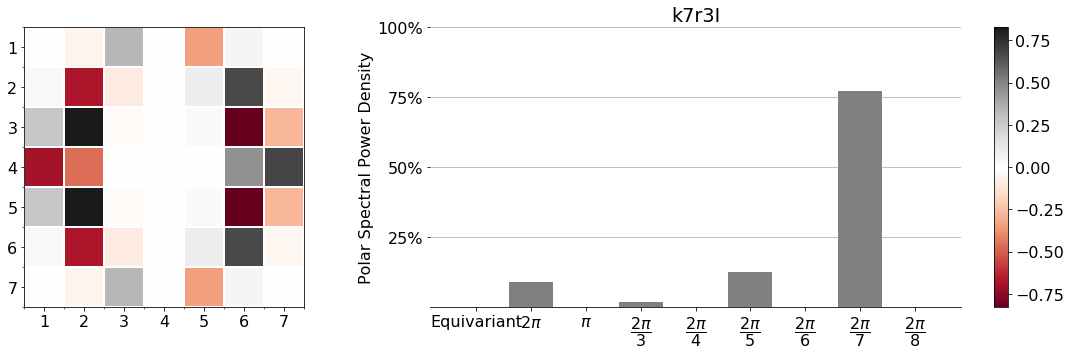

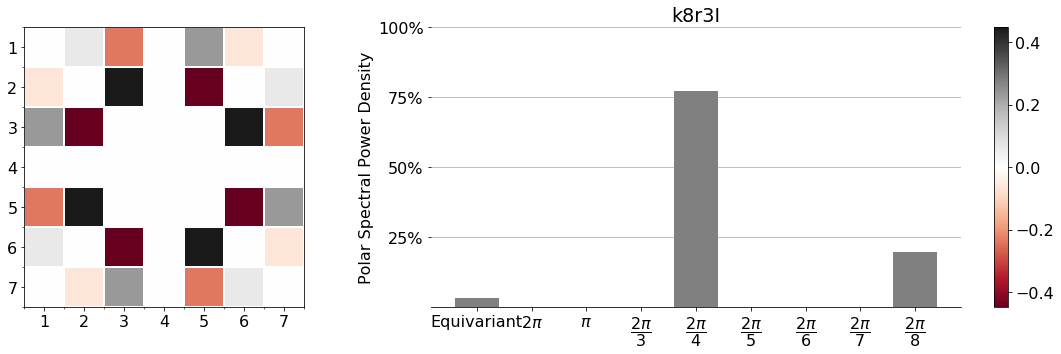

In [21]:
base = SteerableKernelBase.create_from_rk(4)
print(len(base.base))
for i, k_label in enumerate(base.kernels_label):
    plot_filter(base.base[i], spd=16, colorbar=True)
    plt.title(k_label)

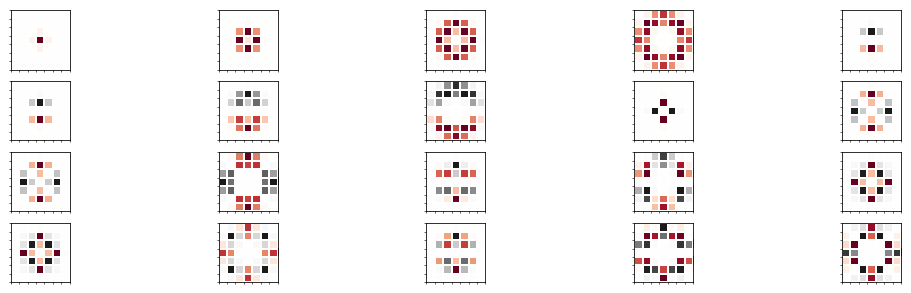

In [36]:
I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(4,5)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        plot_filter(base.base[i*4+j], plot=axs[i][j], axis=False)

### Cos Sin Combination Test

In [22]:
base = SteerableKernelBase.create_from_rk(4)
alpha = torch.linspace(0, 2*np.pi, 4)
k_max = 5
kalpha = torch.stack([k*alpha for k in range(1,k_max+1)])
true_cos_sin_kalpha = torch.stack([torch.cos(kalpha), torch.sin(kalpha)])

In [23]:
from lib.steered_conv.steerable_filters import cos_sin_ka, cos_sin_ka_stack
fast_cos_sin_kalpha = cos_sin_ka_stack(torch.cos(alpha), torch.sin(alpha), k_max)
diff = true_cos_sin_kalpha-fast_cos_sin_kalpha
print('Average Diff:')
pd.DataFrame({'cos':diff[0].mean(-1), 'sin': diff[0].mean(-1)}, index=list(range(1,k_max+1)))

ModuleNotFoundError: No module named 'lib'

### Steerable Test

In [24]:

base = SteerableKernelBase.create_from_rk(4)
x = torch.linspace(-2,2,5)
x,y = torch.meshgrid(x,x)
K = x+y
K = K.reshape(1,1,5,5)
K = clip_pad_center(K, base.base.shape)

info = {}

W = base.approximate_weights(K, info)
print(f'mse:{info["mse"]:.3f}, r2:{info["r2"]:.3f}')

torch.set_printoptions(precision=3, sci_mode=False)
print(W)


mse:0.017, r2:0.992
tensor([[[     0.000,     -0.000,      0.000,      0.000,      0.290,
               1.863,      1.154,     -0.000,      0.000,      0.000,
               0.383,     -0.827,     -0.000,      0.000,      0.067,
              -0.741,      0.000,      0.230,     -0.000,      0.290,
               1.863,      1.154,     -0.000,      0.000,     -0.000,
              -0.383,      0.827,     -0.000,      0.000,      0.067,
              -0.741,     -0.000,     -0.230,     -0.000]]])


**Checking weight approximation**

mse:0.017, r2:0.992


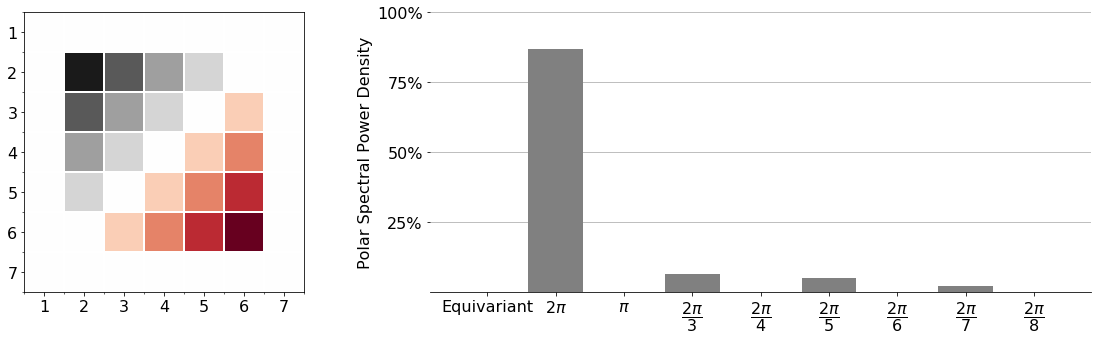

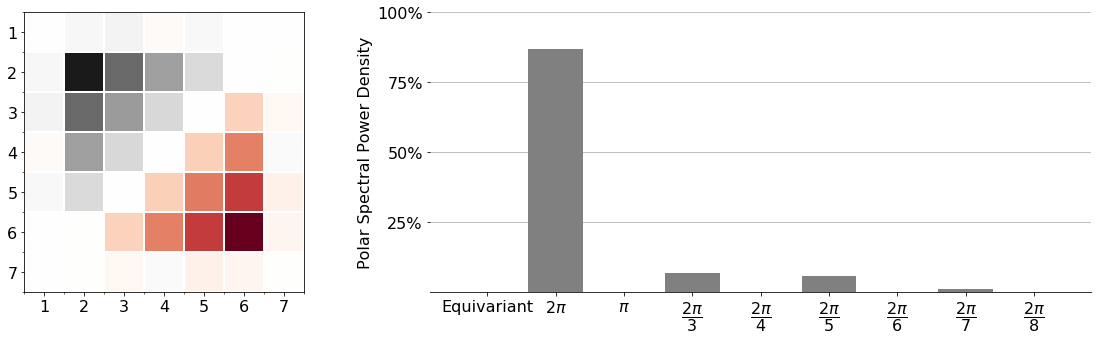

In [30]:
plot_filter(K[0,0], spd=True)
plot_filter(info['y_approx'][0,0], spd=True)
print(f'mse:{info["mse"]:.3f}, r2:{info["r2"]:.3f}')


**Checking filter rotation for different steer angle $\alpha$**

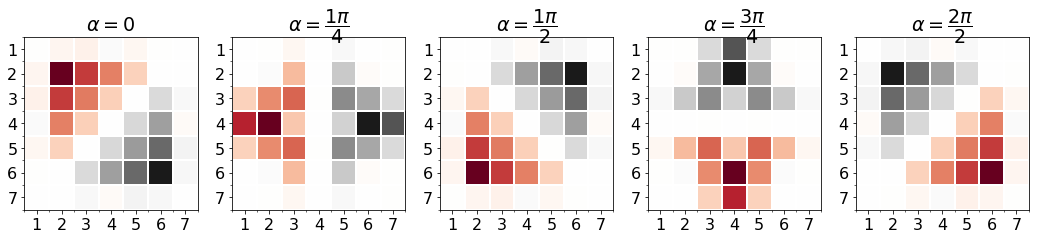

In [31]:
I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(1,5)
N = len(axs)-1
alphas = np.linspace(0, np.pi, N+1, endpoint=True)
for i in range(N+1):
    plot_filter(base.conv2d(I,W, alpha=alphas[i])[0,0], plot=axs[i])
    if i==0:
        axs[i].set_title('$\\alpha=0$')
    elif i%2 or N%2:
        axs[i].set_title('$\\alpha = \dfrac{%i \pi}{%i}$' % (i, N))
    else:
        axs[i].set_title('$\\alpha = \dfrac{%i \pi}{%i}$' % (i//2, N/2))